In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
sys.path.insert(1, "../python/functions")
sys.path.insert(2, "../python/architecture")

In [3]:
from data_prep_functions import mnist_prep
from model_functions import *
from plotting_functions import *
import no_gpu
import reproducible

In [4]:
def enkf_classifier(X_train,
                    X_test,
                    y_train,
                    y_test,
                    layers,
                    neurons,
                    particles,
                    epochs,
                    batch_size = None,
                    h_0 = 2,
                    delta = 0.005,
                    epsilon = 0.5,
                    randomization = False,
                    shuffle = True,
                    early_stopping = False,
                    early_stopping_diff = 0.001
                    ):

    """ Function to define the structure of a neural network.


    Parameters:

    X_train (np.ndarray): Training data X.
    X_test (np.ndarray): Test data X.
    y_train (pd.DataFrame): Training data y.
    y_test (pd.DataFrame): Test data y.
    layers (int): Number of layers.
    neurons (list): Number of neurons in each layer.
    particles (int): Number of particles in the ensemble.
    epochs (int): Number of epochs.
    batch_size (None or int): Size of the batches. Must be between 0 and the number of observations in the training set.
    h_0 (int or float): Starting step size.
    delta (float): Constant for numerical stability in the jacobian.
    epsilon (float): Constant for numerical stability in the step size.
    randomization (bool): Whether or not to add noise to the particles and randomize them around their mean.
    shuffle (bool): Whether or not to shuffle the data prior to each epoch.
    early_stopping (bool): Whether or not to stop the calculation when the changes get small.
    early_stopping_diff (bool): Minimum change before early stopping is applied.


    Returns:

    mean_model (tensorflow.python.keras.engine.sequential.Sequential): The final model.
    mean_model_train_acc (list): Training accuracies of the averaged model after each epoch.
    mean_model_test_acc (list): Test accuracies of the averaged model after each epoch.

    """

    if batch_size == None:
        batch_size = len(X_train)

    n_cols = X_train.shape[1]

    n = len(X_train)
    num_batches = int(np.ceil(n / batch_size))
    batch_indices = np.cumsum([0] + list(np.ones(num_batches) * batch_size))
    batch_indices[-1] = n

    model_dict = {}
    weights_dict = {}
    y_pred_dict = {}
    jacobian_dict = {}
    weights_vector_dict = {}
    train_acc_dict = {}
    test_acc_dict = {}
    iteration_dict = {}

    # init_model already has weights and biases following the Glorot distribution
    # it can already be used to predict and evaluate, but it is very bad (<10% accuracy)
    # only used to determine shapes and shape_elements via its weights
    init_model = nn_model_structure(layers = layers,
                                    neurons = neurons,
                                    n_cols = n_cols)
    init_model = nn_model_compile(init_model,
                                  optimizer = "sgd")
    weights = init_model.get_weights()
    # shape contains the shapes of the weight matrices and bias vectors as a list of arrays
    shapes = [np.array(params.shape) for params in weights]
    # shape_elements contains the indices of the weights as a vector and tells where to cut
    shape_elements = np.cumsum([0] + [np.prod(shape) for shape in shapes])

    for i in range(particles):
        # just an initial model with the correct structure regarding neurons, layers, activation functions, Glorot initialization
        model = nn_model_structure(layers = layers,
                                   neurons = neurons,
                                   n_cols = n_cols)
        model = nn_model_compile(model,
                                 optimizer = "sgd")
        # for every particle write the model in a dictionary
        model_dict["model_{}".format(str(i+1))] = model

        # for every particles write the weights and biases in a dictionary
        weights_dict["model_{}".format(str(i+1))] = model_dict["model_{}".format(str(i+1))]\
                                                        .get_weights()

        train_acc_dict["model_{}".format(str(i+1))] = []
        test_acc_dict["model_{}".format(str(i+1))] = []
        iteration_dict["model_{}".format(str(i+1))] = []

    # mean_model as the model with the mean of the weights of all particle models
    mean_weights = list(np.mean(list(weights_dict.values()), axis = 0))
    mean_model = init_model
    mean_model.set_weights(mean_weights)

    mean_model_train_acc = np.array(mean_model.evaluate(X_train, y_train, verbose = 0)[1])
    mean_model_test_acc = np.array(mean_model.evaluate(X_test, y_test, verbose = 0)[1])

    # loop over all epochs
    for epoch in range(epochs):
        # early stopping
        if early_stopping:
            if epoch == 0:
                train_acc_old = 0
                test_acc_old = 0
            else:
                train_acc_new = mean_model_train_acc[epoch]
                test_acc_new = mean_model_test_acc[epoch]
                if np.absolute(test_acc_new - test_acc_old) <= early_stopping_diff and np.absolute(train_acc_new - train_acc_old) <= early_stopping_diff:
                    print("STOP: Early Stopping after epoch {} because improvement in training accuracy is only {} and in test accuracy only {}."\
                                                                         .format(epoch+1, train_acc_new - train_acc_old, test_acc_new - test_acc_old))
                    return mean_model, mean_model_train_acc, mean_model_test_acc
                test_acc_old = test_acc_new
        # shuffle the data
        if shuffle:
            indices = y_train.sample(frac=1).index
            X_batches = [X_train[indices][int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]
            y_batches = [y_train.iloc[indices].reset_index(drop = True)[int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]
        # loop over all batches
        for b in range(num_batches):
            for i in range(particles):
                # set new weights for model
                model_dict["model_{}".format(str(i+1))].set_weights(weights_dict["model_{}".format(str(i+1))])

                # for every particle write the predictions on the training batches in a dictionary
                y_pred_dict["model_{}".format(str(i+1))] = model_dict["model_{}".format(str(i+1))]\
                                                                .predict(X_batches[b])

                # for every particle write the Jacobian in a dictionary
                jacobian_dict["model_{}".format(str(i+1))] = (-1) * np.multiply(np.array(y_batches[b]),
                                                                                np.array(1 / (y_pred_dict["model_{}".format(str(i+1))] + delta)))

            # compute the mean of the predictions
            y_pred_mean = np.mean(list(y_pred_dict.values()), axis = 0)

            # compute the matrix D elementwise
            d = np.zeros(shape = (particles, particles))
            for k in range(particles):
                y_pred_centered = y_pred_dict["model_{}".format(str(k+1))] - y_pred_mean
                for j in range(particles):
                    d[k][j] = np.sum(np.multiply(y_pred_centered, jacobian_dict["model_{}".format(str(j+1))]))
            d = np.transpose(d)

            # compute the scalar h_t
            h_t = h_0 / (np.sqrt(np.sum(d**2)) + epsilon)

            # Reshape the weights and biases so that they are no longer matrices and vectores, but now one single vector
            for i in range(particles):
                weights_array = np.array([])
                for j in range(len(weights_dict["model_{}".format(str(i+1))])):
                    weights_array = np.append(weights_array, np.reshape(weights_dict["model_{}".format(str(i+1))][j], (1, -1)).ravel())
                weights_vector_dict["model_{}".format(str(i+1))] = weights_array

            # matrix with particle parameters as row vectors
            weights_all_ptcls = np.array(list(weights_vector_dict.values()))

            # compute the matrix with the updates for each particle
            weights_all_ptcls = weights_all_ptcls - h_t * np.matmul(d, weights_all_ptcls)

            for i in range(particles):
                # write the updates back into the dictionary
                weights_vector_dict["model_{}".format(str(i+1))] = weights_all_ptcls[i]
                # reshape the updates, so that they are of the original matrx and vector shape
                for l in range(len(shape_elements)-1):
                    start = shape_elements[l]
                    end = shape_elements[l+1]
                    weights_dict["model_{}".format(str(i+1))][l] = np.reshape(weights_vector_dict["model_{}".format(str(i+1))][start:end], tuple(shapes[l]))
                if randomization:
                    # add randomization/ noise to each particle
                    new_weights = []
                    # standard deviation for scaled Glorot distribution
                    for s in range(len(shapes)):
                        if shapes[s].shape[0] == 2:
                            fan_in = shapes[s][0]
                            fan_out = shapes[s][1]
                        if shapes[s].shape[0] == 1:
                            fan_in = shapes[s-1][0]
                            fan_out = shapes[s][0]
                        stddev = np.sqrt(np.sqrt(h_t)) * np.sqrt(2 / (fan_in + fan_out))
                        noise = np.random.normal(loc = 0.0,
                                                 scale = stddev,
                                                 size = tuple(shapes[s]))
                        new_weights.append(weights_dict["model_{}".format(str(i+1))][s] + noise)
                    weights_dict["model_{}".format(str(i+1))] = new_weights

        if randomization:
            # randomize particles around their mean
            weights_mean = list(np.mean(list(weights_dict.values()), axis = 0))
            for i in range(particles):
                new_weights = []
                # standard deviation for Glorot distribution
                for s in range(len(shapes)):
                    if shapes[s].shape[0] == 2:
                        fan_in = shapes[s][0]
                        fan_out = shapes[s][1]
                    if shapes[s].shape[0] == 1:
                        fan_in = shapes[s-1][0]
                        fan_out = shapes[s][0]
                    stddev = np.sqrt(2 / (fan_in + fan_out))
                    noise = np.random.normal(loc = 0.0,
                                             scale = stddev,
                                             size = tuple(shapes[s]))
                    new_weights.append(weights_mean[s] + noise)
                weights_dict["model_{}".format(str(i+1))] = new_weights

        for i in range(particles):
            # for every particle write the training accuracy of the current iteration in a dictionary
            train_acc_dict["model_{}".format(str(i+1))].append(model_dict["model_{}".format(str(i+1))]\
                                                                      .evaluate(X_train, y_train, verbose = 0)[1])

            # for every particle write the test accuracy of the current iteration in a dictionary
            test_acc_dict["model_{}".format(str(i+1))].append(model_dict["model_{}".format(str(i+1))]\
                                                                      .evaluate(X_test, y_test, verbose = 0)[1])

            # for every particle write the current iteration in a dictionary
            iteration_dict["model_{}".format(str(i+1))].append("Epoch: {}, Batch: {}.".format(epoch+1, b+1))

        # update the mean_model
        mean_weights = list(np.mean(list(weights_dict.values()), axis = 0))
        mean_model.set_weights(mean_weights)

        mean_model_train_acc = np.append(mean_model_train_acc, np.array(mean_model.evaluate(X_train, y_train, verbose = 0)[1]))
        mean_model_test_acc = np.append(mean_model_test_acc, np.array(mean_model.evaluate(X_test, y_test, verbose = 0)[1]))

    return mean_model, mean_model_train_acc, mean_model_test_acc

In [5]:
X_train, X_val, y_train, y_val = mnist_prep()

In [6]:
# use samller dataset for increased speed
X_train_small = X_train[:1000, :]
X_val_small = X_val[:500, :]
y_train_small = y_train[:1000]
y_val_small = y_val[:500]

n_cols = X_train_small.shape[1]

In [7]:
X_train = X_train_small
X_test = X_val_small
y_train = y_train_small
y_test = y_val_small

In [8]:
batch_size = 50     # len(X_train)
epochs = 10
particles = 50
early_stopping = False
early_stopping_diff = 0.001
shuffle = True
randomization = False

In [9]:
layers = 5
neurons = [128, 128, 64, 32, 10]
n_cols = X_train.shape[1]

In [10]:
delta = 0.005
h_0 = 2
epsilon = 0.5

In [11]:
import time
start_time = time.time()

In [12]:
mean_model, mean_model_train_acc, mean_model_test_acc = enkf_classifier(X_train,
                                                                        X_test,
                                                                        y_train,
                                                                        y_test,
                                                                        layers,
                                                                        neurons,
                                                                        particles,
                                                                        epochs,
                                                                        batch_size,
                                                                        h_0,
                                                                        delta,
                                                                        epsilon,
                                                                        randomization,
                                                                        shuffle,
                                                                        early_stopping,
                                                                        early_stopping_diff)

In [13]:
end_time = time.time()
print("Calculation time: {} minutes.".format((end_time - start_time) / 60))

Calculation time: 13.497794306278228 minutes.


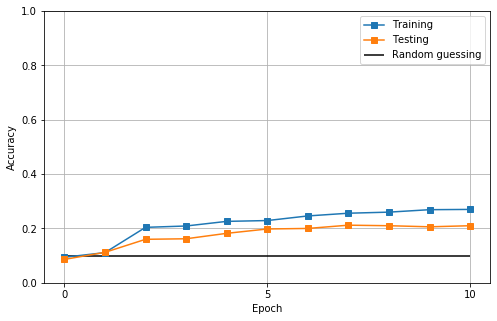

In [14]:
nn_plot_epoch_acc(mean_model_train_acc,
                  mean_model_test_acc,
                  mean_comparison = 0.1,
                  savefig = False,
                  file = "../img/enkf_model_mnist_E{}_B{}_P{}_H{}.png".format(epochs, batch_size, particles, h_0))